# Setup

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rc = {
    "font.family": "sans",
    "font.size": 10,
    "axes.axisbelow": True,
    "grid.linestyle": '--',
    "axes.grid": True,
    "mathtext.fontset": "cm",
    "grid.alpha": 0.3
}

plt.rcParams.update(rc)


# Data prep

In [95]:
from q_factor import get_q_df


In [96]:
q_values = get_q_df('./data/QVALUES.txt')

q_values['Q'] = q_values['Q'] * 1

q_values


,i_ref,Q
0,0.0,22.709
1,0.1,27.925
2,0.2,32.978
3,0.3,38.767
4,0.4,46.492
5,0.5,56.466
6,0.6,68.512
7,0.7,84.725
8,0.8,115.720
9,0.9,164.860


# Testing the numerical methods



## Behavior without $Q$ instability

In [97]:
from q_factor import q_func_polynomial
from methods import secant, mod_secant, bisection


In [98]:
def build_test(test_dict: dict,
               q_values: pd.DataFrame,
               q_func_polynomial: callable,
               method: callable,
               include_q_drop=False):

    a = test_dict['a']
    b = test_dict['b']
    seek = test_dict['seek']
    tol = test_dict['tol']
    MAX_ITER = test_dict['max_iter']

    x = np.arange(0, 1, 1e-3)
    f = q_func_polynomial(x, q_values, deg=9, include_q_drop=include_q_drop)

    results = method(a, b, seek, tol, f, MAX_ITER, debug=True)

    return results


In [99]:
def multiple_seeks_test(start, stop, step, method_label, test_dict_copy, *args, **kwargs):
    multiple_seeks = np.arange(start, stop, step)
    m_seeks_records = []

    for seek in multiple_seeks:
        test_dict_copy['seek'] = seek
        
        m_seeks_dict = dict()

        r = build_test(*args, **kwargs)

        m_seeks_dict['Method'] = method_label
        m_seeks_dict['Seek'] = seek
        m_seeks_dict['Iters-to-converge'] = r['iter'].iat[-1]
        m_seeks_dict['c'] = r['c'].iat[-1]
        m_seeks_dict['f(c)'] = r['f(c)'].iat[-1]

        m_seeks_records.append(m_seeks_dict)

    return pd.DataFrame(m_seeks_records)


In [100]:
def get_mock_y(include_q_drop):
  x = np.arange(0, 1, 1e-3)
  f = q_func_polynomial(x, q_values, include_q_drop=include_q_drop)
  y = f(x)

  return y


In [101]:
test_dict = {
    'a': 0.0,
    'b': 1.0,
    'seek': 110,
    'tol': 30,
    'max_iter': 32
}

mock_dict = {
  'x': np.arange(0, 1, 1e-3),
  'y': get_mock_y(include_q_drop=False),
  'y_with_drop': get_mock_y(include_q_drop=True),
}

test_dict_copy = test_dict.copy()

In [102]:
res_secant = build_test(test_dict, q_values,
                        q_func_polynomial,
                        secant,
                        include_q_drop=False)

res_mod_sec = build_test(test_dict,
                         q_values,
                         q_func_polynomial,
                         mod_secant,
                         include_q_drop=False)

res_bisect = build_test(test_dict,
                        q_values,
                        q_func_polynomial,
                        bisection,
                        include_q_drop=False)


In [103]:
res_secant.tail()

,iter,a,b,c,f(c),error
3,4,0.479866,1.120945,0.502544,57.028494,-52.971506
4,5,1.120945,0.502544,0.523456,59.379481,-50.620519
5,6,0.502544,0.523456,0.973731,248.961601,138.961601
6,7,0.523456,0.973731,0.643685,74.313694,-35.686306
7,8,0.973731,0.643685,0.711124,87.462432,-22.537568


In [104]:
res_mod_sec.tail()

,iter,a,b,c,f(c),error
0,1,0.8,1.0,0.7943,113.472012,3.472012


In [105]:
res_bisect.tail()

,iter,a,b,c,f(c),error
0,1,0.0,1.0,0.50,56.743276,-53.256724
1,2,0.5,1.0,0.75,98.171202,-11.828798


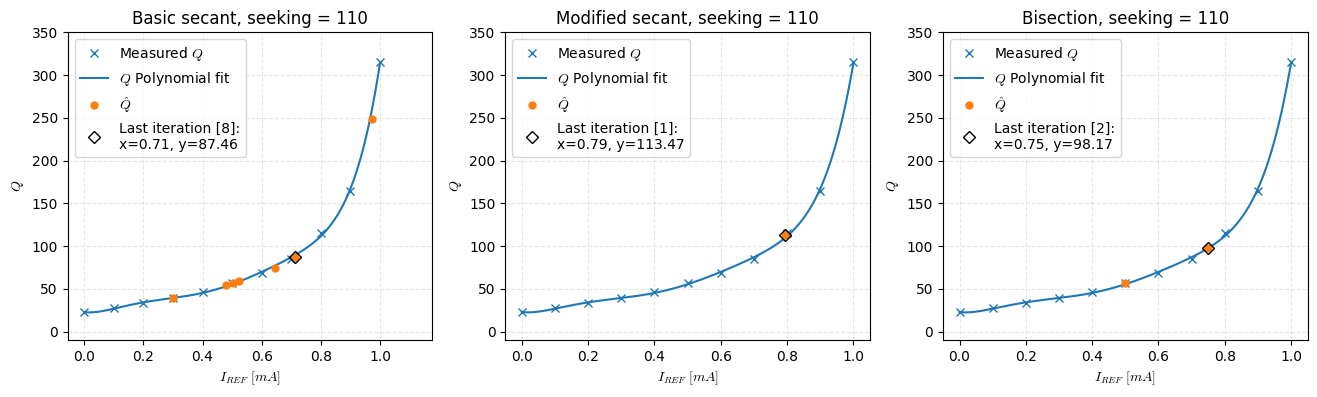

In [106]:
nc = 3
results = [res_secant, res_mod_sec, res_bisect]
titles = ['Basic secant', 'Modified secant', 'Bisection']

fig, ax = plt.subplots(ncols=nc, figsize=(16, 4))

for i in range(nc):
    ax[i].plot(q_values['i_ref'],
               q_values['Q'],
               'x', label='Measured $Q$')

    ax[i].plot(mock_dict['x'],
               mock_dict['y'],
               label='$Q$ Polynomial fit', c='C0')

    ax[i].plot(results[i]['c'],
               results[i]['f(c)'],
               'o', markersize=5, label='$\hat{Q}$')

    last_iref = results[i]['c'].iat[-1]
    last_q = results[i]['f(c)'].iat[-1]
    last_iter = results[i]['iter'].iat[-1]

    ax[i].plot(last_iref,
               last_q,
               'D',
               label=f'Last iteration [{last_iter}]:\nx={last_iref:.2f}, y={last_q:.2f}',
               c='k', fillstyle='none',)

    ax[i].set(
        title=titles[i] + f', seeking = {test_dict["seek"]}',
        xlabel='$I_{REF} \;[mA]$',
        ylabel='$Q$',
        ylim=[-10, 350]
    )
    
for a in ax.flat:
    a.legend()


In [107]:
start = 30
stop = 300
step = 20

test_dict_copy['tol'] = test_dict['tol']
# test_dict_copy['tol'] = 1e-6

multiple_secant = multiple_seeks_test(
    start, stop, step, 
    'Basic secant', test_dict_copy, test_dict_copy, q_values, q_func_polynomial, secant)

multiple_mod_sec = multiple_seeks_test(
    start, stop, step, 
    'Modified secant', test_dict_copy, test_dict_copy, q_values, q_func_polynomial, mod_secant)

multiple_bisection = multiple_seeks_test(
    start, stop, step, 
    'Bisection', test_dict_copy, test_dict_copy, q_values, q_func_polynomial, bisection)


full_sweep = pd.concat([multiple_secant, multiple_mod_sec, multiple_bisection])
full_sweep['c'] = (full_sweep['c']).round(3)


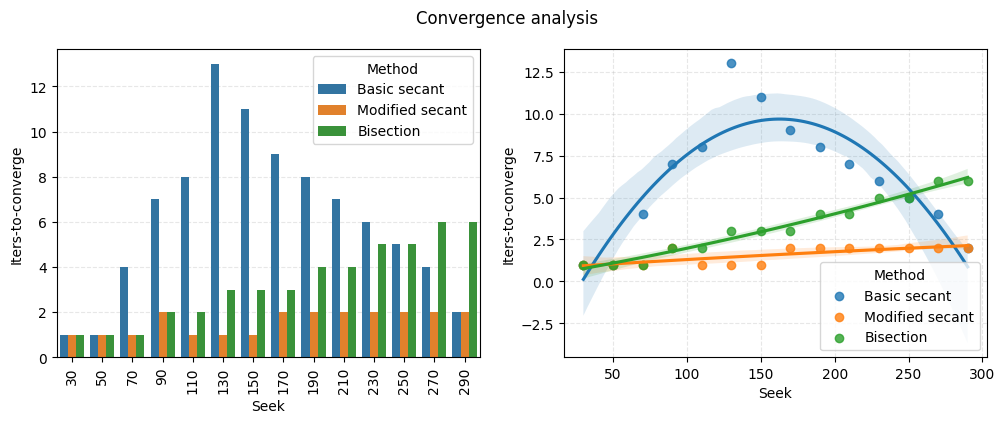

In [108]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)

sns.barplot(data=full_sweep,
            y='Iters-to-converge',
            x='Seek',
            hue='Method',
            orient='v',
            ax=ax[0])

ax[0].set_xticklabels(rotation=90, labels=full_sweep['Seek'].unique())


sns.regplot(data=multiple_secant, x='Seek', y='Iters-to-converge',
            ax=ax[1], order=2, label='Basic secant')

sns.regplot(data=multiple_mod_sec, x='Seek', y='Iters-to-converge',
            ax=ax[1], order=2, label='Modified secant')

sns.regplot(data=multiple_bisection, x='Seek', y='Iters-to-converge',
                        ax=ax[1], order=2, label='Bisection')

ax[1].legend(title='Method')

fig.suptitle('Convergence analysis')


plt.show()


In [109]:
full_sweep

,Method,Seek,Iters-to-converge,c,f(c)
0,Basic secant,30,1,0.025,26.494039
1,Basic secant,50,1,0.093,27.816730
2,Basic secant,70,4,0.487,55.316055
3,Basic secant,90,7,0.646,74.659821
4,Basic secant,110,8,0.711,87.462432
5,Basic secant,130,13,0.810,119.815393
6,Basic secant,150,11,0.834,129.877547
7,Basic secant,170,9,0.925,184.388065
8,Basic secant,190,8,0.914,174.704311
9,Basic secant,210,7,0.928,186.950873


## Behavior with $Q$ instability

In [110]:
q_values_drop = get_q_df('./data/QVALUES.txt', True, 0.9)

q_values_drop

,i_ref,Q
0,0.0,22.709
1,0.1,27.925
2,0.2,32.978
3,0.3,38.767
4,0.4,46.492
5,0.5,56.466
6,0.6,68.512
7,0.7,84.725
8,0.8,115.720
9,0.9,20.000


In [111]:
test_dict['seek'] = 65


In [112]:
res_secant = build_test(test_dict, 
                        q_values_drop,
                        q_func_polynomial,
                        secant,
                        include_q_drop=True)

res_mod_sec = build_test(test_dict,
                         q_values_drop,
                         q_func_polynomial,
                         mod_secant,
                         include_q_drop=True)

res_bisect = build_test(test_dict,
                        q_values_drop,
                        q_func_polynomial,
                        bisection,
                        include_q_drop=True)


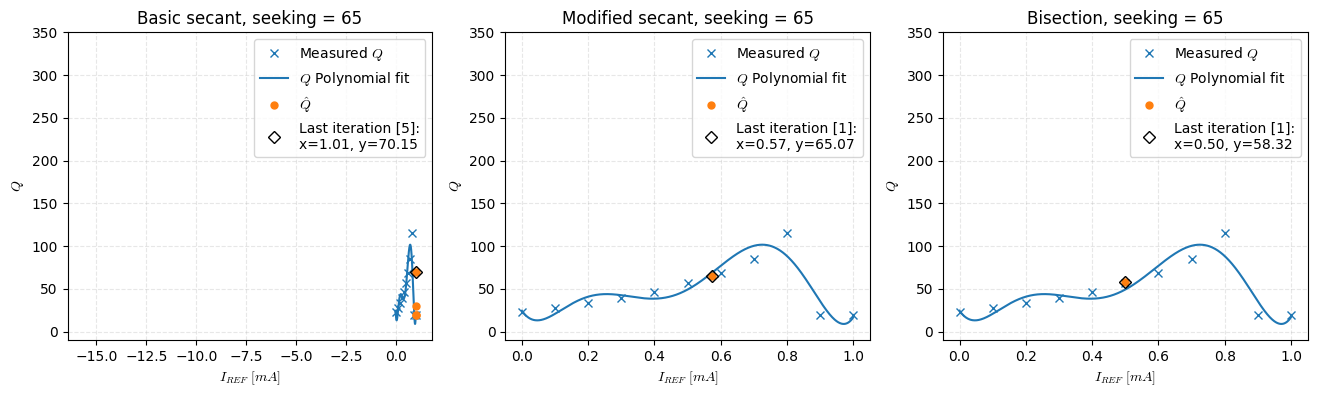

In [113]:
nc = 3
results = [res_secant, res_mod_sec, res_bisect]
titles = ['Basic secant', 'Modified secant', 'Bisection']

fig, ax = plt.subplots(ncols=nc, figsize=(16, 4))

for i in range(nc):
    ax[i].plot(q_values_drop['i_ref'],
               q_values_drop['Q'],
               'x', label='Measured $Q$')

    ax[i].plot(mock_dict['x'],
               mock_dict['y_with_drop'],
               label='$Q$ Polynomial fit', c='C0')

    ax[i].plot(results[i]['c'],
               results[i]['f(c)'],
               'o', markersize=5, label='$\hat{Q}$')

    last_iref = results[i]['c'].iat[-1]
    last_q = results[i]['f(c)'].iat[-1]
    last_iter = results[i]['iter'].iat[-1]

    ax[i].plot(last_iref,
               last_q,
               'D',
               label=f'Last iteration [{last_iter}]:\nx={last_iref:.2f}, y={last_q:.2f}',
               c='k', fillstyle='none',)

    ax[i].set(
        title=titles[i] + f', seeking = {test_dict["seek"]}',
        xlabel='$I_{REF} \;[mA]$',
        ylabel='$Q$',
        ylim=[-10, 350]
    )

for a in ax.flat:
    a.legend()


In [114]:
start = 30
stop = 300
step = 20

test_dict_copy['tol'] = test_dict['tol']
# test_dict_copy['tol'] = 1e-6

multiple_secant = multiple_seeks_test(
    start, stop, step,
    'Basic secant', test_dict_copy, test_dict_copy, q_values_drop, q_func_polynomial, secant)

multiple_mod_sec = multiple_seeks_test(
    start, stop, step,
    'Modified secant', test_dict_copy, test_dict_copy, q_values_drop, q_func_polynomial, mod_secant)

multiple_bisection = multiple_seeks_test(
    start, stop, step,
    'Bisection', test_dict_copy, test_dict_copy, q_values_drop, q_func_polynomial, bisection)


full_sweep = pd.concat([multiple_secant, multiple_mod_sec, multiple_bisection])
full_sweep['c'] = (full_sweep['c']).round(3)


/home/pesadaum/work/tcc/prototype/methods.py:32: RuntimeWarning: invalid value encountered in double_scalars
  slope = (f(b) - f(a))/(b - a)
/home/pesadaum/work/tcc/prototype/methods.py:32: RuntimeWarning: invalid value encountered in double_scalars
  slope = (f(b) - f(a))/(b - a)
/home/pesadaum/work/tcc/prototype/methods.py:32: RuntimeWarning: invalid value encountered in double_scalars
  slope = (f(b) - f(a))/(b - a)
/home/pesadaum/work/tcc/prototype/methods.py:32: RuntimeWarning: invalid value encountered in double_scalars
  slope = (f(b) - f(a))/(b - a)
/home/pesadaum/work/tcc/prototype/methods.py:32: RuntimeWarning: invalid value encountered in double_scalars
  slope = (f(b) - f(a))/(b - a)
/home/pesadaum/work/tcc/prototype/methods.py:32: RuntimeWarning: invalid value encountered in double_scalars
  slope = (f(b) - f(a))/(b - a)
/home/pesadaum/work/tcc/prototype/methods.py:32: RuntimeWarning: invalid value encountered in double_scalars
  slope = (f(b) - f(a))/(b - a)
/home/pesadau

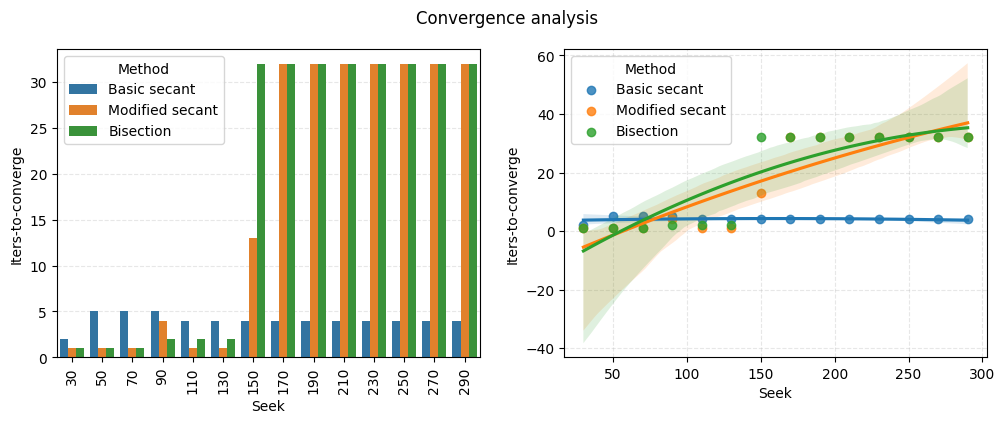

In [115]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)

sns.barplot(data=full_sweep,
            y='Iters-to-converge',
            x='Seek',
            hue='Method',
            orient='v',
            ax=ax[0])

ax[0].set_xticklabels(rotation=90, labels=full_sweep['Seek'].unique())


sns.regplot(data=multiple_secant, x='Seek', y='Iters-to-converge',
            ax=ax[1], order=2, label='Basic secant')

sns.regplot(data=multiple_mod_sec, x='Seek', y='Iters-to-converge',
            ax=ax[1], order=2, label='Modified secant')

sns.regplot(data=multiple_bisection, x='Seek', y='Iters-to-converge',
            ax=ax[1], order=2, label='Bisection')

ax[1].legend(title='Method')

fig.suptitle('Convergence analysis')


plt.show()


In [116]:
full_sweep

,Method,Seek,Iters-to-converge,c,f(c)
0,Basic secant,30,2,1.000,1.999266e+01
1,Basic secant,50,5,1.004,4.532820e+01
2,Basic secant,70,5,1.008,8.278519e+01
3,Basic secant,90,5,1.011,1.072512e+02
4,Basic secant,110,4,NaN,NaN
5,Basic secant,130,4,NaN,NaN
6,Basic secant,150,4,NaN,NaN
7,Basic secant,170,4,NaN,NaN
8,Basic secant,190,4,NaN,NaN
9,Basic secant,210,4,NaN,NaN
